In [1]:
# Set experiment settings

addr  = 'USB0::0x05E6::0x2100::8003733::INSTR'
file  = '%s.dmm.csv'
count = 0

import threading, time, pyvisa, pandas as pd, pint_pandas
from enum import Enum
from ipywidgets import Button

# Create button to save data and close the data acquisition system.
flag = True
def btn_cb(b):
    global flag
    flag = False
btn = Button(
    description  = 'Save and close',
    button_style = 'warning',
    icon         = 'clipboard',
)
btn.on_click(btn_cb)
display(btn)

# Define data recording thread states
class State(Enum):
    NULL = 00
    INIT = 10
    WAIT = 20
    RECV = 30
    SAVE = 40

def read(inst):
    if buf := inst.query_ascii_values('READ?'):
        t = time.perf_counter_ns()
        return buf[-1], t

# Data recording thread
def record():
    global flag                                # DAQ reset flag
    global count                               # Sequential data set number
    data  = []                                 # Data read on State.RECV transition and during state
    state = State.INIT                         # Current measurement state
    old   = State.NULL                         # Prior different state
    
    # Connect to instrument
    mgmt = pyvisa.ResourceManager()            # VISA manager object
    inst = mgmt.open_resource(addr) # VISA Instrument object

    while True:
        # Monitor state transitions
        if state != old:
            print(f'DAQ state: {state}', flush=True)
        old = state
        
        match state:
            # Configure instrument
            case State.INIT:
                data  = []
                
                inst.query(
                    '*CLS;'
                    '*RST;'
                    'CONF:FRES 10000,MAX;:' # Set 4-wire resistance, 100k ohm range, max 6.5 digit resolution
                    'DISP ON;'
                    '*OPC?'
                )
                inst.query('TRIG:SOUR EXT;*OPC?') # Trigger on EXT_TRIG
                state = State.WAIT

            # Triggers recording when blocking read() completes
            case State.WAIT:
                if val := read(inst):
                    data.append(val)
                    inst.query('TRIG:SOUR BUS;*OPC?')
                    state = State.RECV

            # Records until reset
            case State.RECV:
                if flag:
                    if val := read(inst):
                        data.append(val)
                else:
                    state = State.SAVE

            # Save data and reinitialize
            case State.SAVE:
                pd.DataFrame({
                    'Time'       : pd.Series([(val[1] - data[0][1]) / 1e9 for val in data], dtype='pint[second]'),
                    'Resistance' : pd.Series([val[0] for val in data], dtype='pint[ohm]'),
                }).pint.dequantify().to_csv(file % count)
                
                count = count + 1
                state = State.INIT
                
            # Close thread if State.NULL
            case _:
                break

    print('DAQ closed.', flush=True)

# Run data recording thread
thread = threading.Thread(target = record)
thread.start()

Button(button_style='warning', description='Save and close', icon='clipboard', style=ButtonStyle())

DAQ state: State.INIT
DAQ state: State.WAIT
DAQ state: State.RECV
DAQ state: State.SAVE
DAQ state: State.INIT
DAQ state: State.WAIT


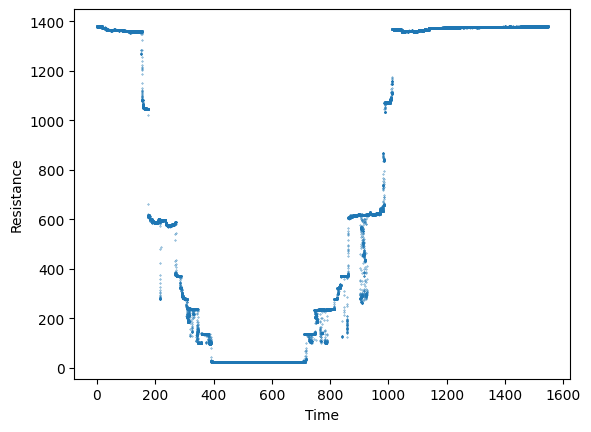

In [2]:
import pandas as pd

for n in ['sensor0 1s 1s 9N 2mms 0 0']:
    df = pd.read_csv(f'{n}.dmm.csv', header=[0], skiprows=[1], index_col=[0])
    df[df.Resistance < 1e30].plot.scatter(x='Time', y='Resistance', s=0.1)